In [3]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fun
import numpy as np
import pandas as pd

# Load do dataset

In [4]:
from lib.data import load_dataset

rs = 2

x_train, y_train, x_valid, y_valid = load_dataset('dts/dts_all/train.csv',rs=rs)
x_test = load_dataset('dts/dts_all/test.csv',test_only=True,rs=rs)

# Normalização

In [5]:
from sklearn.preprocessing import StandardScaler
from my_nn import dts

sc = StandardScaler()
sc.fit(x_train.values)

x_train = sc.transform(x_train.values)
x_valid = sc.transform(x_valid.values)
x_test = sc.transform(x_test.values)

# Feature Selection

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

selec_mod = SelectFromModel(estimator=LogisticRegression(random_state=rs, max_iter=2000)).fit(x_train, y_train)

x_train = selec_mod.transform(x_train)
x_valid = selec_mod.transform(x_valid)
x_test = selec_mod.transform(x_test)

# Dataloaders

In [7]:
from torch.utils.data import DataLoader
train_dts = dts(x_train,y_train)
valid_dts = dts(x_valid,y_valid)

training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dts, batch_size=32, shuffle=True)

In [8]:
from my_nn import nnModel

model = nnModel(inFeatures = x_train.shape[1], random_state=2)

losses, accs = model.fit(
    trainloader=training_loader,
    validloader=valid_loader,
    learningRate=0.02,
    momentum=0.9,
    gamma=0.97,
    numEpochs=31,
    verbose=False
)

[317.55787336826324, 148.5313034178689, 101.23674896219745, 76.28170832176693, 64.8421388163697, 49.26658786213375, 36.33276155762724, 30.051663950252987, 30.36737964621716, 25.243738389652208, 18.12520775736084, 17.42363931540376, 19.92515180184421, 19.579402021970054, 9.927372811906253, 4.508216697681576, 7.222082515438046, 4.2086169513601845, 6.114327610651607, 6.299342768097262, 3.375550937635161, 3.2719125044706487, 3.2387427858969855, 3.2225191133675715, 3.210673897345764, 3.2013040924209326, 3.1942579265086266, 3.183910099662712, 3.179598279294734, 3.1756801697617765, 3.1727374194107245]
[96.675, 97.1875, 98.075, 98.1625, 98.3, 98.325]


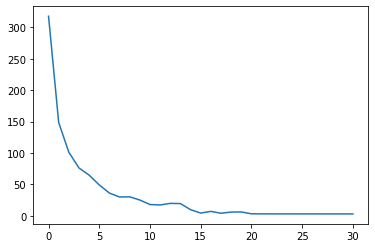

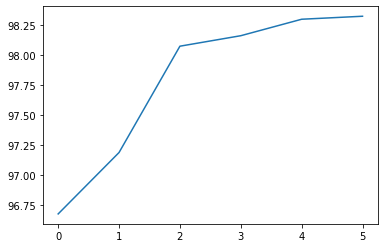

In [9]:
print(losses)
print(accs)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(losses)
plt.figure()
plt.plot(accs)

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

yvalid = model.predict(torch.tensor(x_valid, dtype=torch.float32))

print("Acc: {:.3f}".format(accuracy_score(y_true=y_valid, y_pred=yvalid)))
print("ROC: {:.3f}".format(roc_auc_score(y_valid, yvalid)))
print("Acc: {:.3f}".format(precision_score(y_true=y_valid, y_pred=yvalid)))
print("Acc: {:.3f}".format(recall_score(y_true=y_valid, y_pred=yvalid)))

Acc: 0.983
ROC: 0.983
Acc: 0.987
Acc: 0.979


In [11]:
ypred = model.predict(torch.tensor(x_test, dtype=torch.float32))
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)